# **Bank Marketing DataSet - Intelligent Targeting**

Marketing campaigns are characterized by focusing on the customer needs and their overall satisfaction. Nevertheless, there are different variables that determine whether a marketing campaign will be successful or not. Some important aspects of a marketing campaign are as follows: 

**Segment of the Population:** To which segment of the population is the marketing campaign going to address and why? This aspect of the marketing campaign is extremely important since it will tell to which part of the population should most likely receive the message of the marketing campaign. 

**Distribution channel to reach the customer's place:** Implementing the most effective strategy in order to get the most out of this marketing campaign. What segment of the population should we address? Which instrument should we use to get our message out? (Ex: Telephones, Radio, TV, Social Media Etc.) 

**Promotional Strategy:** This is the way the strategy is going to be implemented and how are potential clients going to be address. This should be the last part of the marketing campaign analysis since there has to be an in-depth analysis of previous campaigns (If possible) in order to learn from previous mistakes and to determine how to make the marketing campaign much more effective.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# **EDA**

In [3]:

train = pd.read_csv('Data/Train.csv')


Lets go and explore our training and test datasets. We will do the following steps:

1. Brief Look at the Dataset
2. See the dataset shape.
3. Target Distribution.
4. See the variables datatypes.
5. See the number of missing/null values.
6. See the number of unique values in each variable. 


#### **1. Brief look at the dataset**.

In [4]:
train.head(3)


,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0


In [5]:
ID_COL, TARGET_COL = 'id', 'term_deposit_subscribed'

#### **2. Dataset Shape (Number of Samples and Variables in the dataset)**

In [6]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')


features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 31647 samples and 18 variables

The dataset contains 16 features


#### 3. **Target Distribution**

In [7]:
train[TARGET_COL].value_counts(normalize=True)

0    0.892754
1    0.107246
Name: term_deposit_subscribed, dtype: float64

Visually we are able to see communicate things more clearly and graphs help us do that. Lets visualize the same target distribution in a countplot.

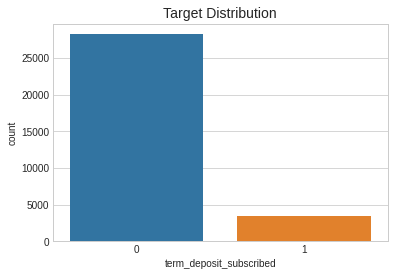

In [8]:
_ = sns.countplot(train[TARGET_COL])
_ = plt.title("Target Distribution", fontsize=14)

Quite obviously dataset is very imbalanced. Only about 10 % of the examples are positive.

#### **4. Variable Datatypes**

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                31647 non-null  object 
 1   customer_age                      31028 non-null  float64
 2   job_type                          31647 non-null  object 
 3   marital                           31497 non-null  object 
 4   education                         31647 non-null  object 
 5   default                           31647 non-null  object 
 6   balance                           31248 non-null  float64
 7   housing_loan                      31647 non-null  object 
 8   personal_loan                     31498 non-null  object 
 9   communication_type                31647 non-null  object 
 10  day_of_month                      31647 non-null  int64  
 11  month                             31647 non-null  object 
 12  last

#### **5. Null Values**

In [10]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

days_since_prev_campaign_contact    81.6
customer_age                        2.0 
balance                             1.3 
last_contact_duration               1.0 
personal_loan                       0.5 
marital                             0.5 
num_contacts_in_campaign            0.4 
job_type                            0.0 
education                           0.0 
default                             0.0 
term_deposit_subscribed             0.0 
housing_loan                        0.0 
prev_campaign_outcome               0.0 
communication_type                  0.0 
day_of_month                        0.0 
month                               0.0 
num_contacts_prev_campaign          0.0 
id                                  0.0 
dtype: float64

#### **6. Unique values in each variable**

In [11]:
train.nunique()

id                                  31647
customer_age                        77   
job_type                            12   
marital                             3    
education                           4    
default                             2    
balance                             6563 
housing_loan                        2    
personal_loan                       2    
communication_type                  3    
day_of_month                        31   
month                               12   
last_contact_duration               1447 
num_contacts_in_campaign            46   
days_since_prev_campaign_contact    511  
num_contacts_prev_campaign          41   
prev_campaign_outcome               4    
term_deposit_subscribed             2    
dtype: int64

### **Analyzing Each Variable & their relationships**

In [12]:
train.columns

Index(['id', 'customer_age', 'job_type', 'marital', 'education', 'default',
       'balance', 'housing_loan', 'personal_loan', 'communication_type',
       'day_of_month', 'month', 'last_contact_duration',
       'num_contacts_in_campaign', 'days_since_prev_campaign_contact',
       'num_contacts_prev_campaign', 'prev_campaign_outcome',
       'term_deposit_subscribed'],
      dtype='object')

### Segregating Categorical & Numerical Variables

In [13]:
cat_cols = ['job_type',
 'marital',
 'education',
 'default',
 'housing_loan',
 'personal_loan',
 'communication_type',
 'month',
 'prev_campaign_outcome']

In [14]:
num_cols = [c for c in features if c not in cat_cols]
num_cols

['customer_age',
 'balance',
 'day_of_month',
 'last_contact_duration',
 'num_contacts_in_campaign',
 'days_since_prev_campaign_contact',
 'num_contacts_prev_campaign']

### **Categorical Features**

#### **Univariate Analysis**

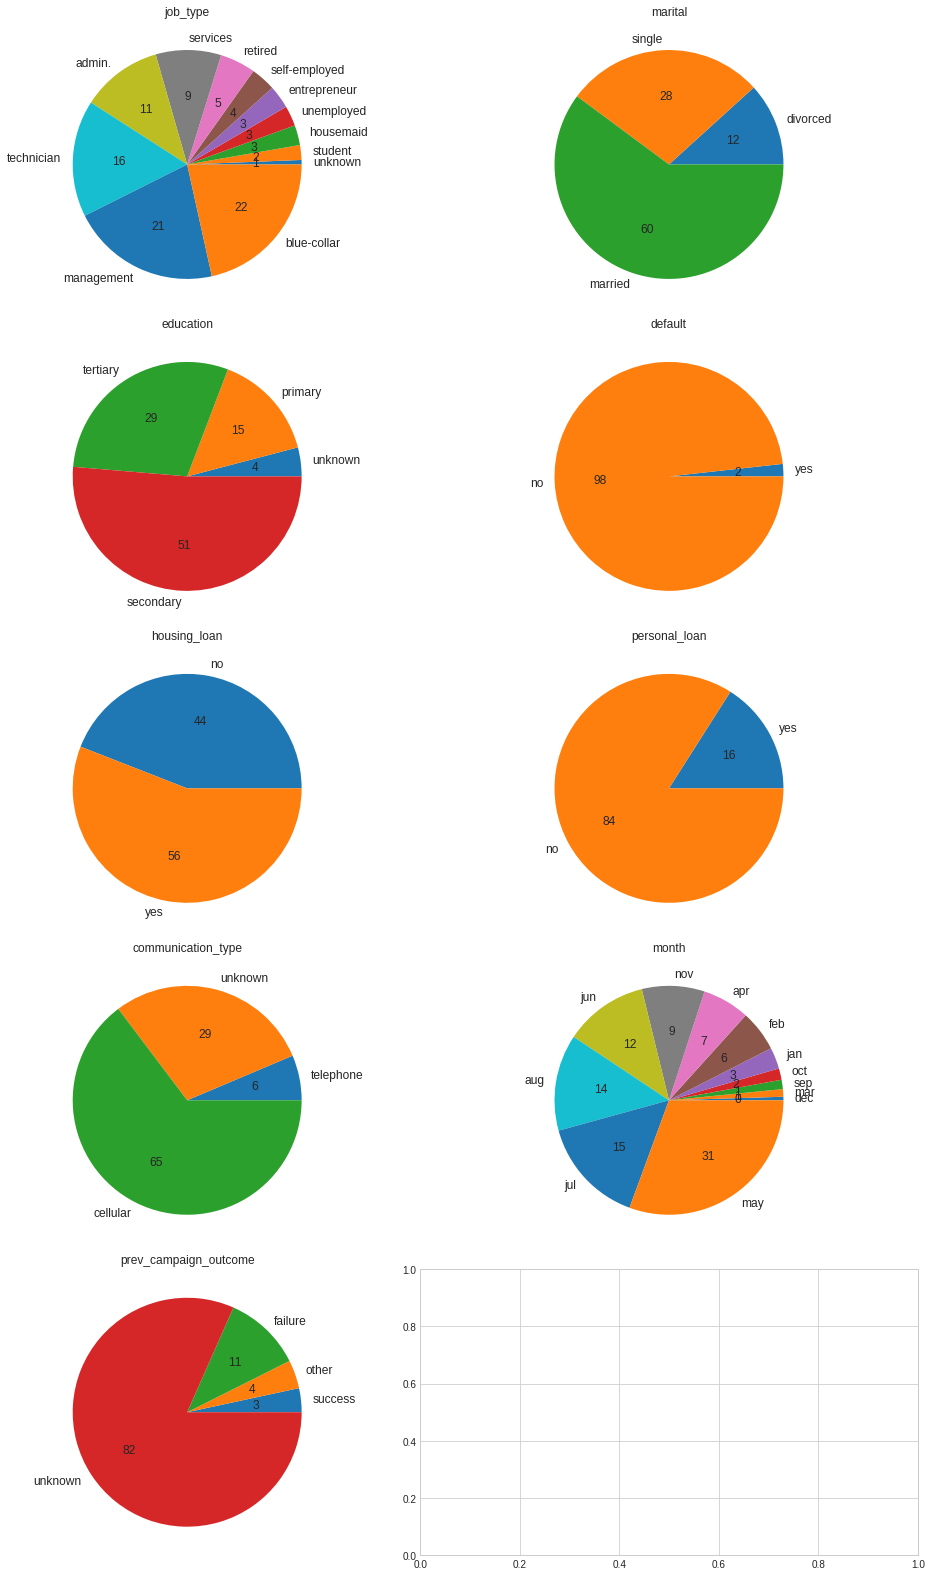

In [15]:
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=12)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

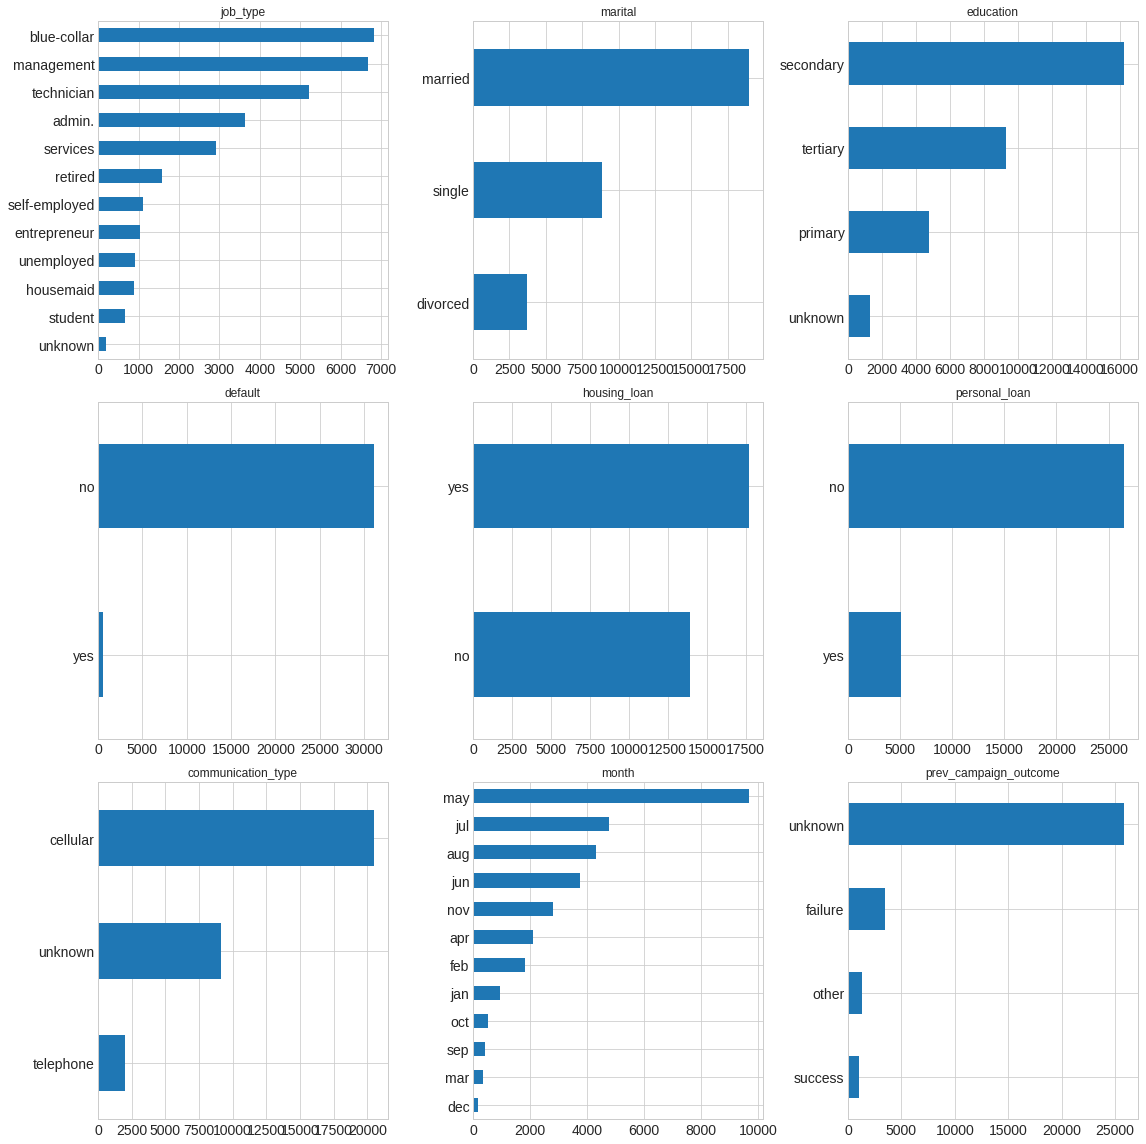

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

##### **Bivariate Analysis Relationships with Target**

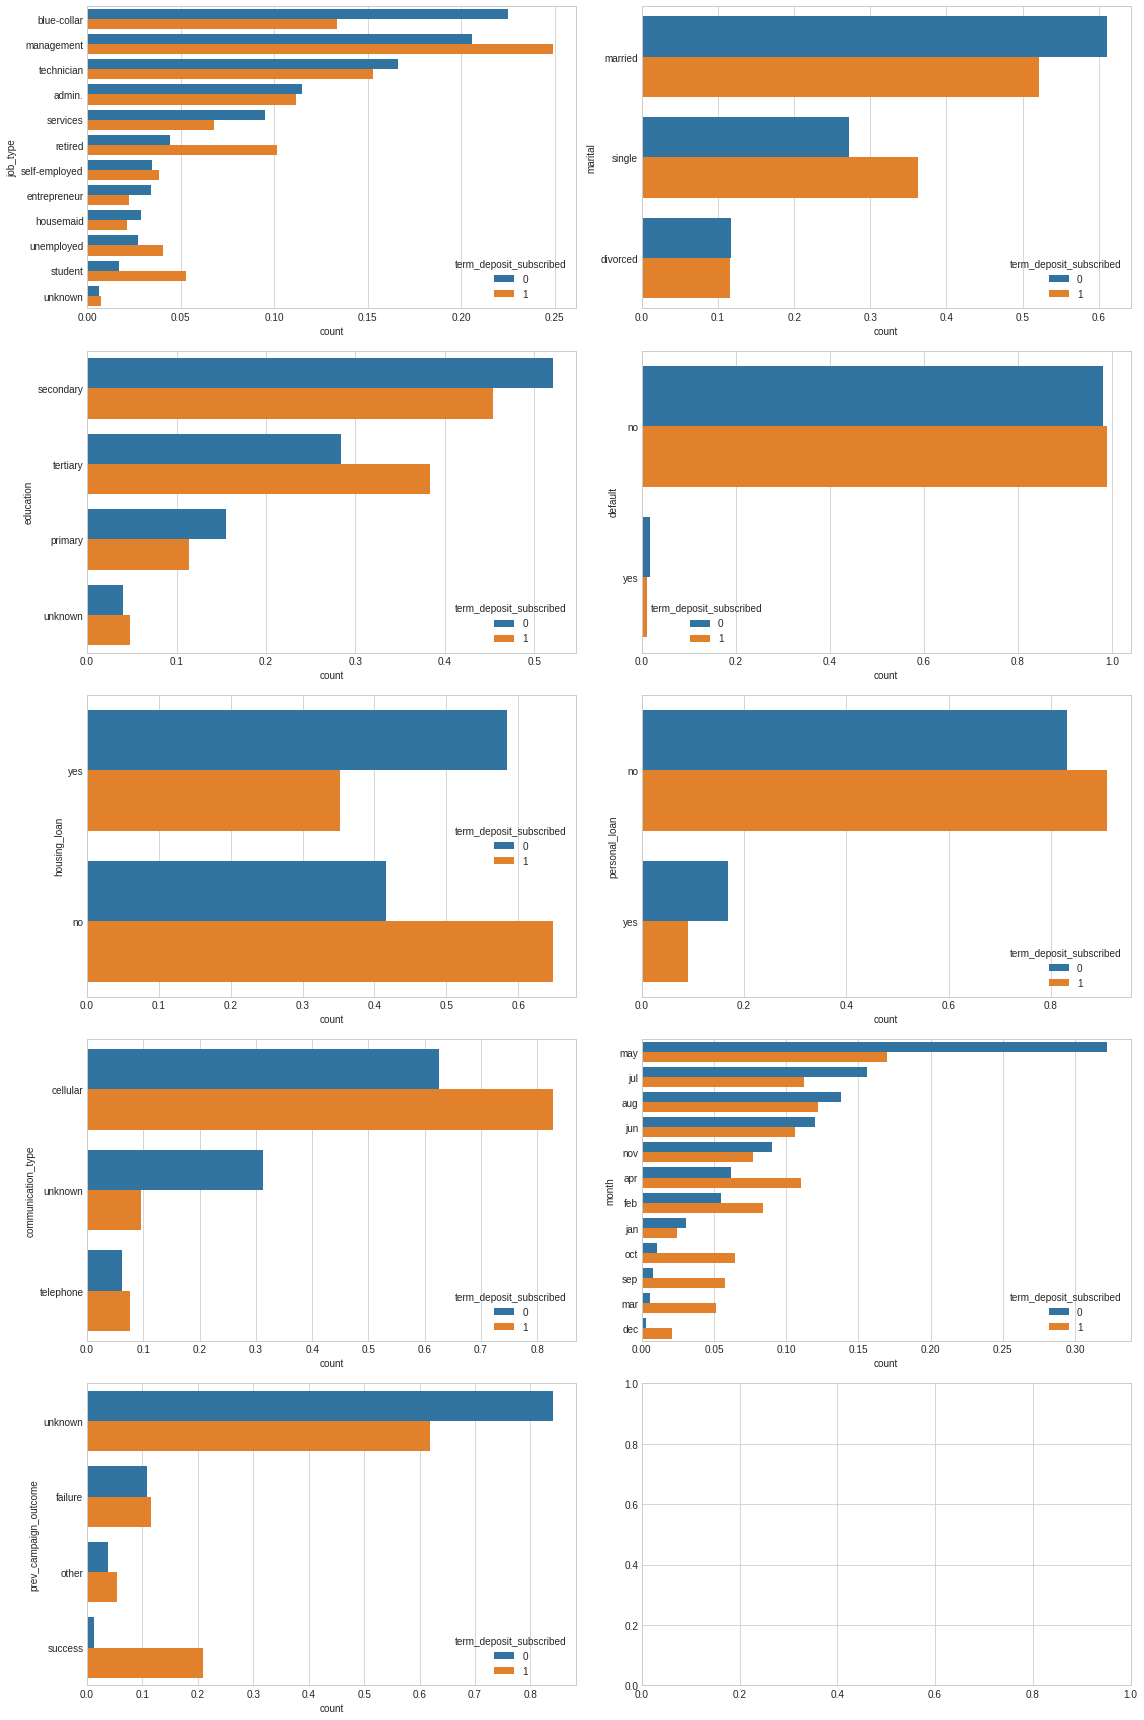

In [17]:

fig, axes = plt.subplots(5, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    fltr = train[TARGET_COL] == 0
    vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_b = train[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a[TARGET_COL] = 0
    vc_b[TARGET_COL] = 1

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)

    _ = sns.barplot(y = c, x = 'count', data =df , hue=TARGET_COL, ax=axes[i])
    
_ = plt.tight_layout()

**Q. Do married people have more chances of subscribing to a term deposit ?**


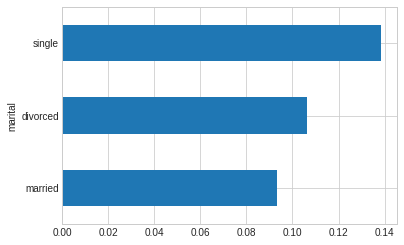

In [18]:
_ = train.groupby('marital')[TARGET_COL].mean().sort_values().plot(kind = 'barh')

The data tells us single people are the more likely to subscribe to a term deposit. 

#### **Numerical Features**

##### 1. **Univariate Analysis - Boxplots**




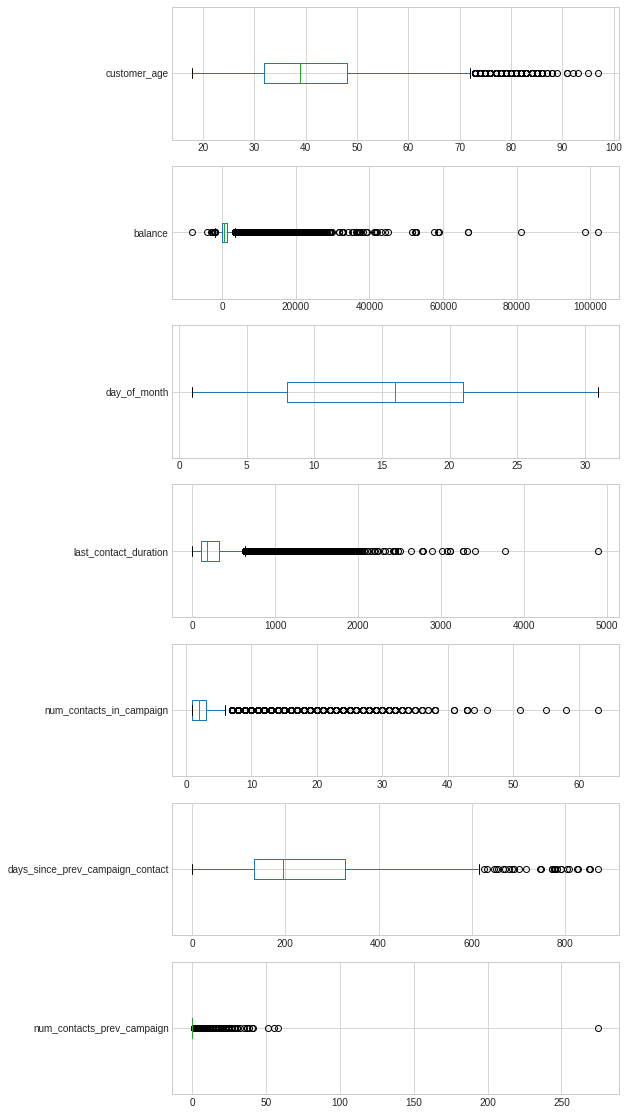

In [19]:
fig, axes = plt.subplots(7, 1, figsize=(8, 20))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

##### **2. Univariate Analysis - Density Plots**


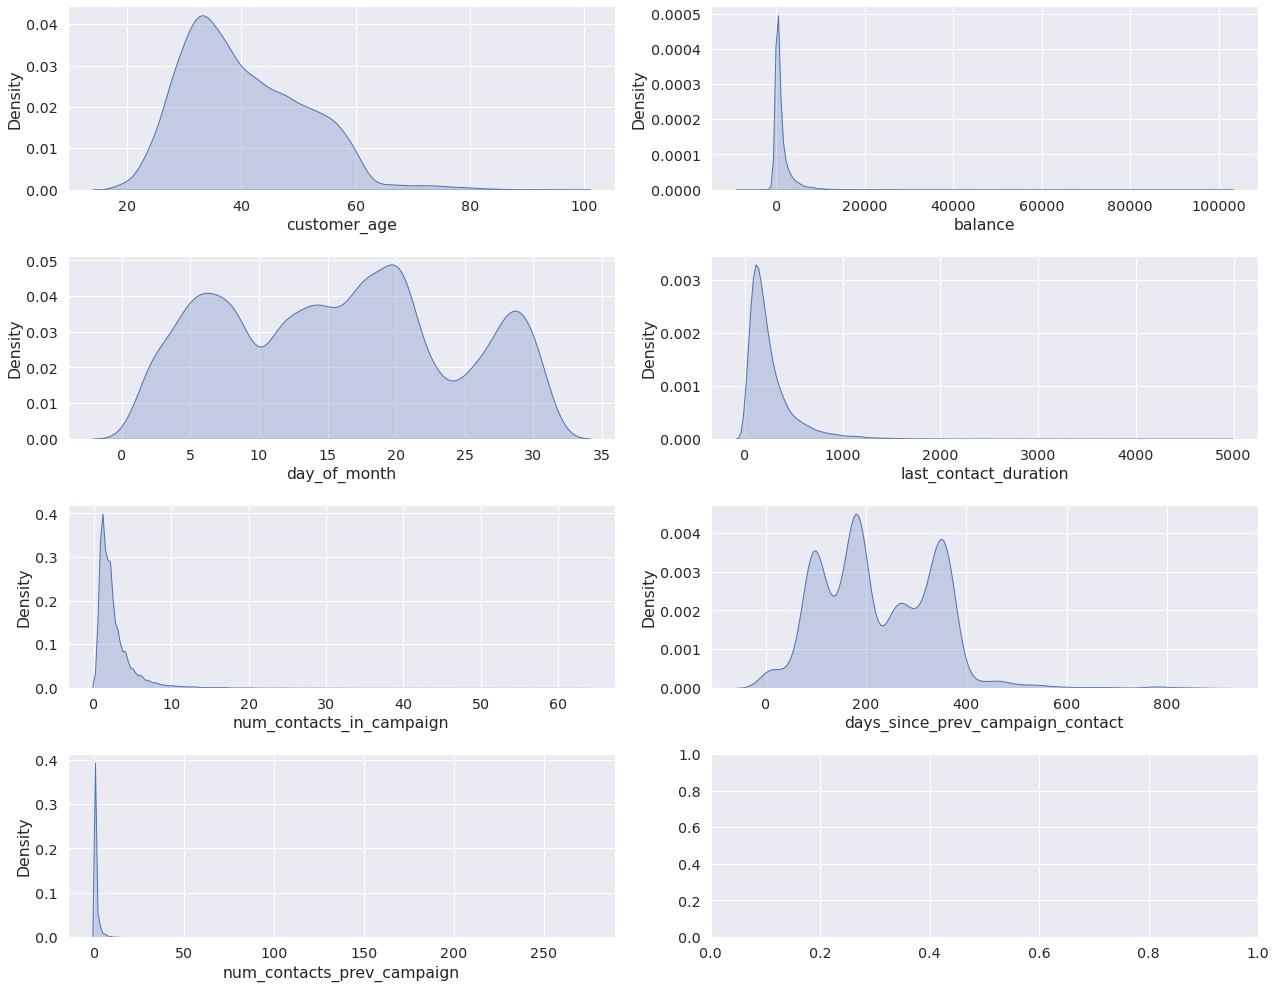

In [20]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

##### **3. Bivariate Analysis KDE plots - Relationships with Target Variable**.

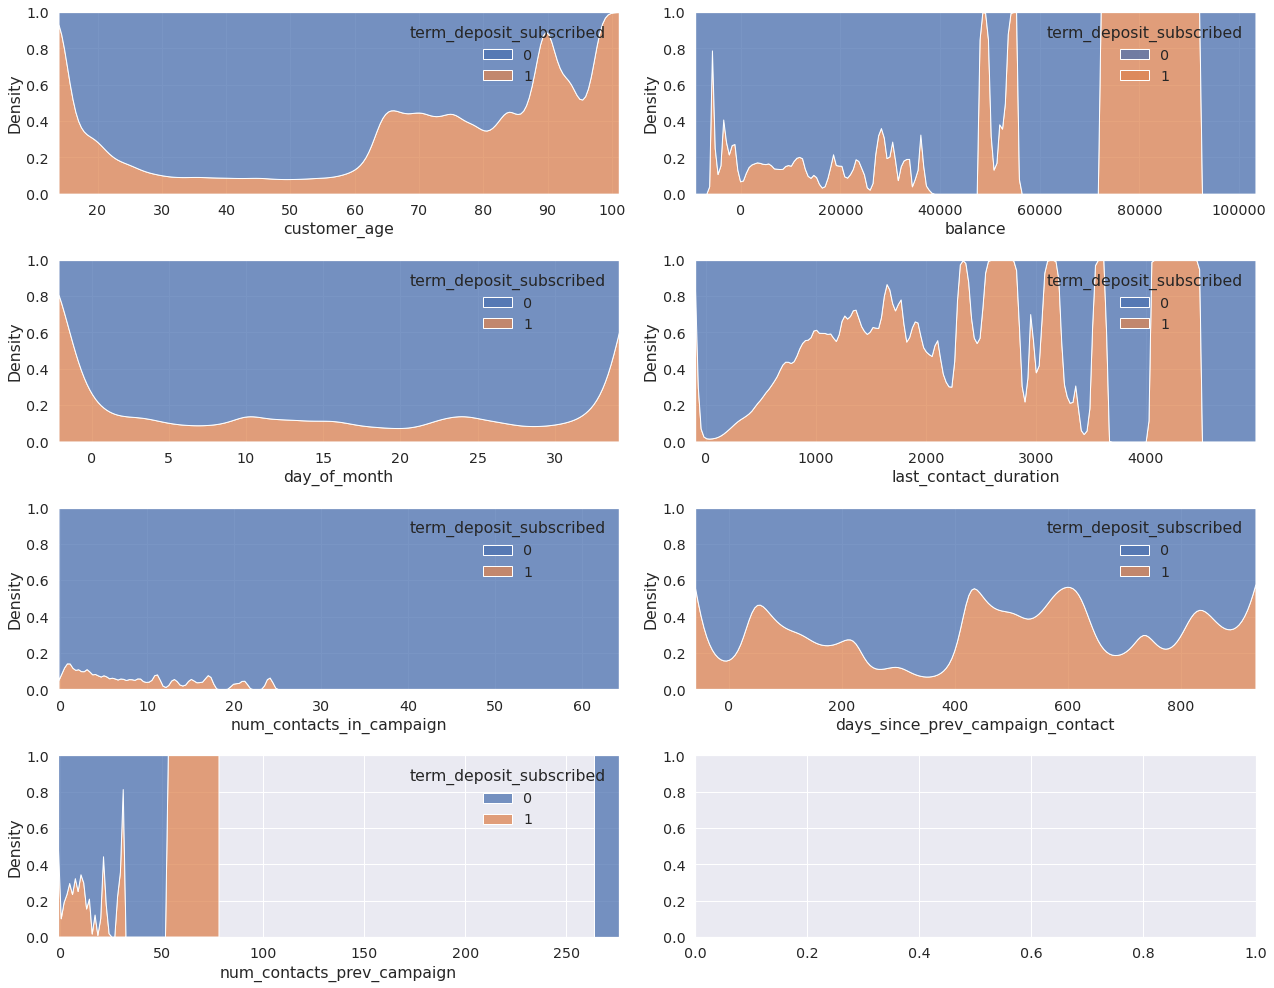

In [21]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, hue=TARGET_COL, multiple='fill', ax=axes[i])
plt.tight_layout()

##### **4. Bivariate Analysis - Horizontal BarPlots**



**We are using median since median is not affected by outliers**, and our data has a lot of outlers

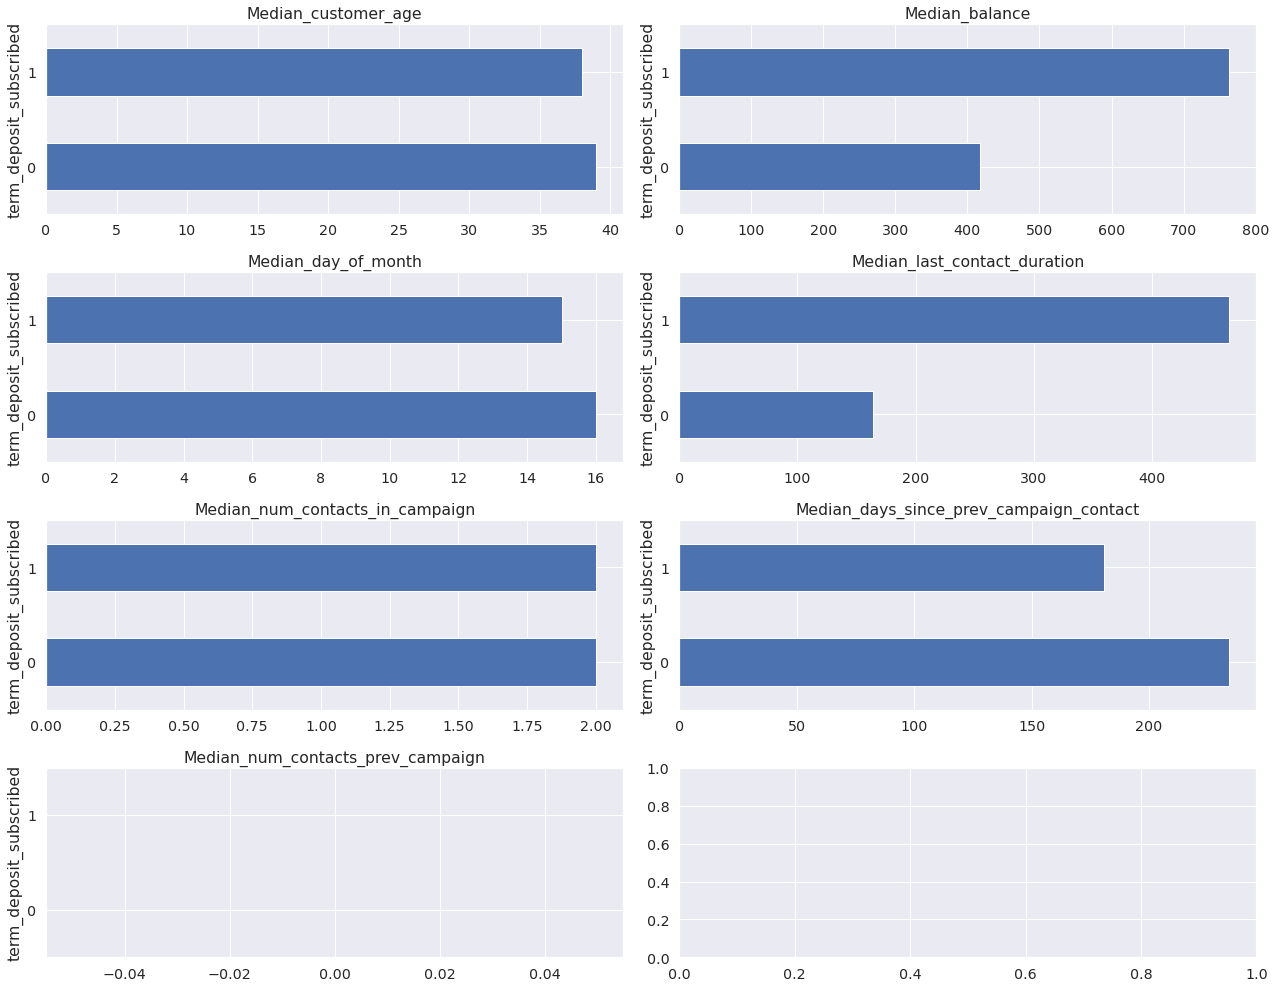

In [22]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

**Q. Do people with a higher bank balance more likely subscribe to term deposit than people with low balance ?**

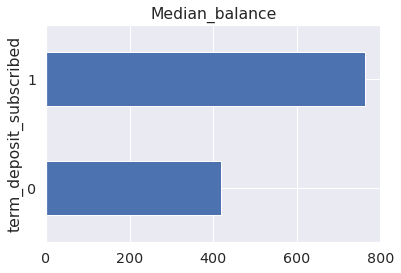

In [23]:
_ = train.groupby(TARGET_COL)['balance'].median().plot(kind = 'barh', title=f'Median_balance')

the above figure is definetly support the our initial hypothesis is that higher bank balance more likely subscribe to term deposit than people with low balance

**Q. Does the length of the call made to the customers tell us anything about their chances of subscribing ?**

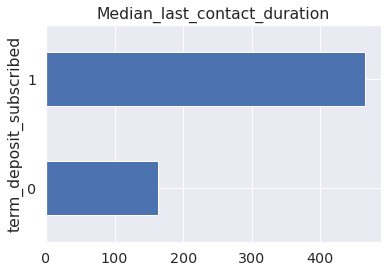

In [24]:
_ = train.groupby(TARGET_COL)['last_contact_duration'].median().plot(kind = 'barh', title=f'Median_last_contact_duration')

From the plot above median last_call_duration made to the customers not subscribing to a term deposit is around 150 seconds. Median last_call_duration made to the customers subscribing to a term deposit is around 450 seconds. So yes our hypothesis seems true.

##### **5. Bivariate Analysis - Correlation Heatmaps**

<Figure size 1008x576 with 0 Axes>

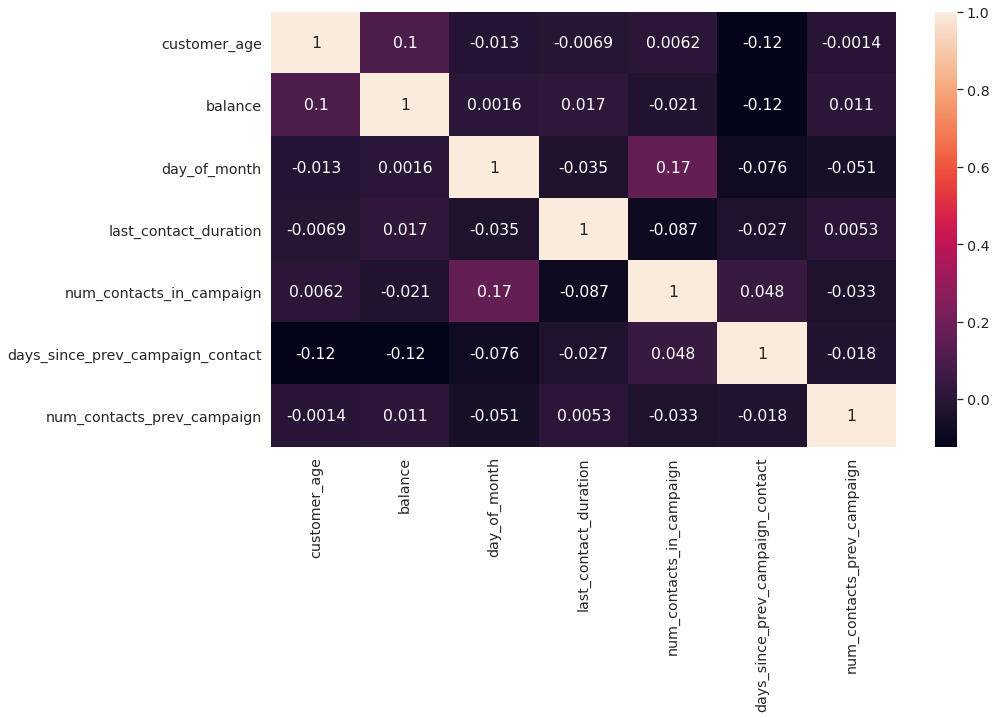

In [25]:
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train[num_cols].corr(), annot=True)